In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.7.0'

In [4]:
session = tf.Session()

## Example 1: linear regression

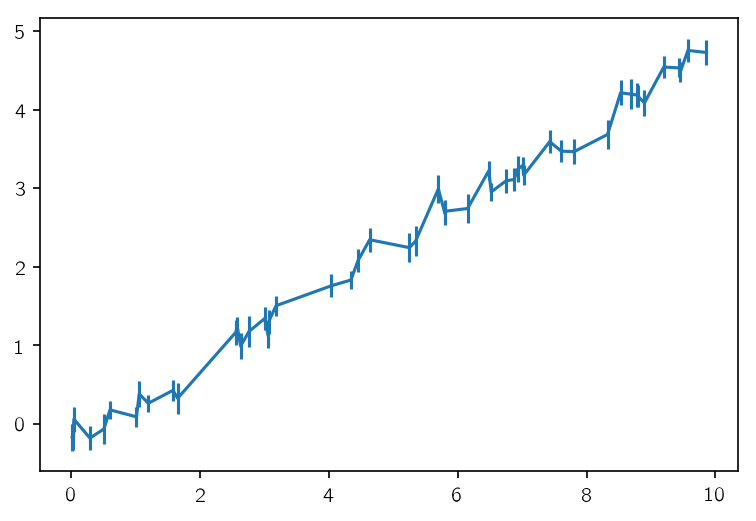

In [5]:
x = np.sort(np.random.uniform(0, 10, 50))
yerr = np.random.uniform(0.1, 0.2, len(x))
y = 0.5 * x - 0.2 + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr=yerr);

In [6]:
import numpy as np

ivar = 1.0 / yerr**2
A = np.vander(x, 2)
ATA = np.dot(A.T, A*ivar[:, None])
ATy = np.dot(A.T, y*ivar)
w = np.linalg.solve(ATA, ATy)
print(w)

[ 0.50227099 -0.23364147]


In [7]:
import tensorflow as tf

ivar = tf.constant(1.0 / yerr**2)
A = tf.constant(np.vander(x, 2))
ATA = tf.matmul(A, A*ivar[:, None], transpose_a=True)
ATy = tf.matmul(A, (y*ivar)[:, None], transpose_a=True)
w = tf.linalg.solve(ATA, ATy)
print(tf.Session().run(w))

[[ 0.50227099]
 [-0.23364147]]


In [8]:
print(w)

Tensor("MatrixSolve:0", shape=(2, 1), dtype=float64)


In [9]:
m = tf.Variable(0.5, dtype=tf.float64)
b = tf.Variable(-0.2, dtype=tf.float64)
log_s = tf.Variable(np.log(0.2), dtype=tf.float64)
s = tf.exp(log_s)

model = m * x + b
log_like = -0.5 * tf.reduce_sum(((y - model) / s) ** 2)
log_like -= 0.5 * len(x) * tf.log(2*np.pi*s**2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(log_like))
    print(sess.run(tf.gradients(log_like, [m, b, log_s])))

22.057298050423206
[-141.03963644530648, -33.03509420719563, -25.064658177903656]


In [10]:
from tensorflow.contrib.opt import ScipyOptimizerInterface

Instructions for updating:
Use the retry module or similar alternatives.


In [11]:
var_list = [m, b, log_s]
opt = ScipyOptimizerInterface(-log_like, var_list)

In [12]:
session.run(tf.global_variables_initializer())
opt.minimize(session)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -27.867291
  Number of iterations: 17
  Number of functions evaluations: 19


In [13]:
session.run(var_list)

[0.5021694556572668, -0.23737515495266498, -1.97628895549526]

In [14]:
import simple_hmc

In [15]:
metric = simple_hmc.DiagonalMetric(3, 1./np.abs(session.run(tf.hessians(log_like, var_list))))

In [27]:
results = simple_hmc.tf_simple_nuts(session, log_like, var_list, 5000, 0.5, metric)

100%|██████████| 5000/5000 [00:39<00:00, 125.89it/s]


In [28]:
results[-1]

0.7740009408460355

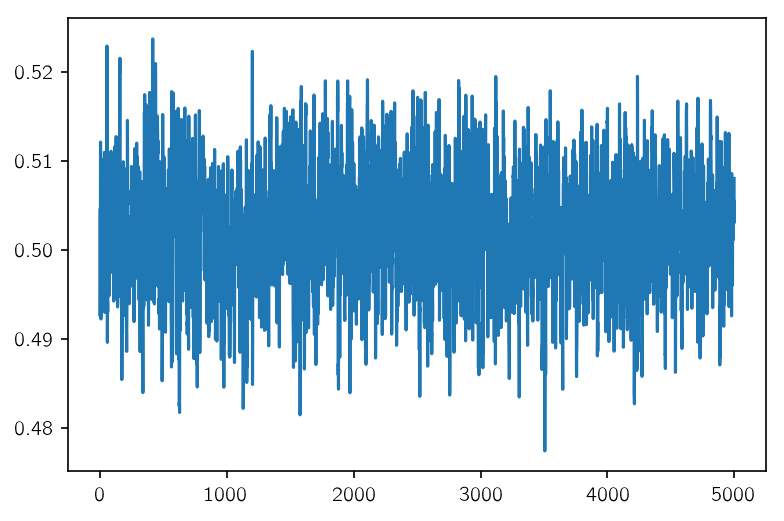

In [29]:
plt.plot(results[0][:, 0])

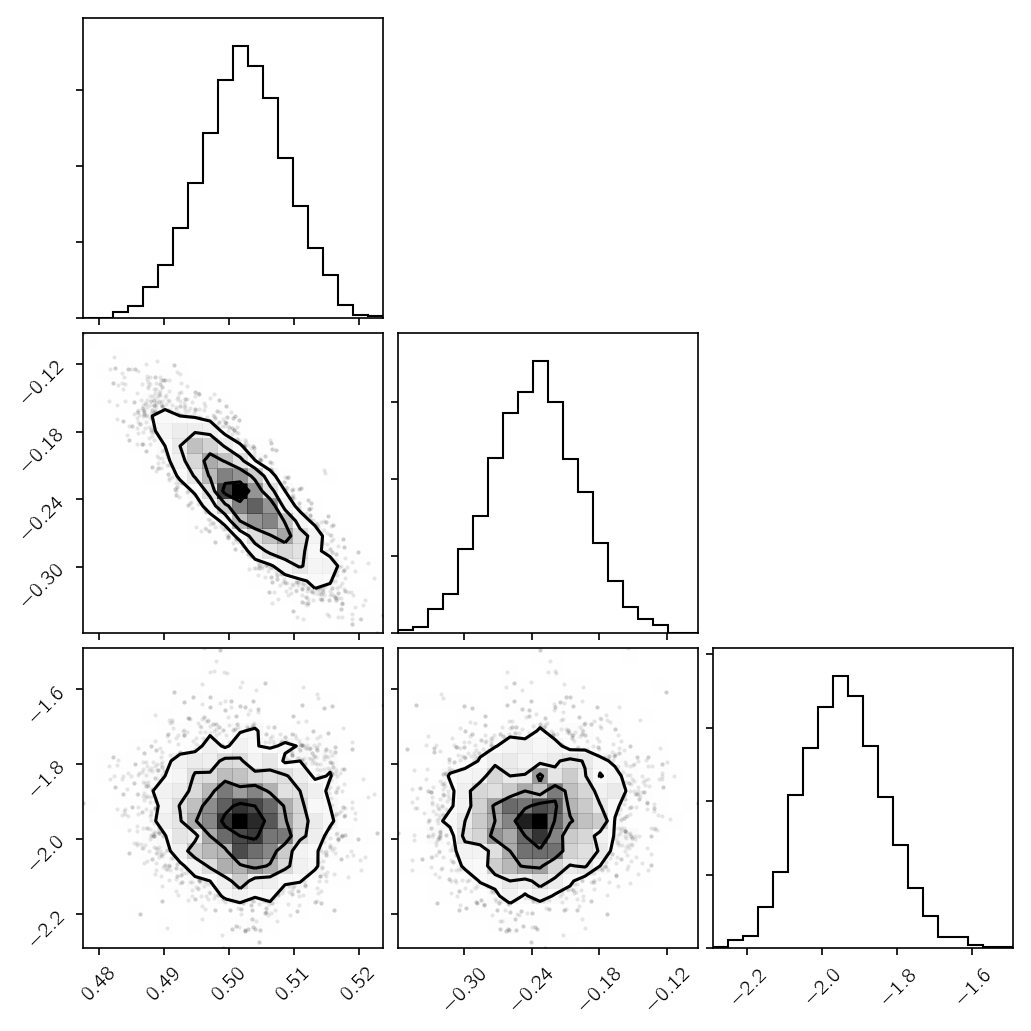

In [30]:
import corner
corner.corner(results[0]);

In [70]:
results = simple_hmc.tf_simple_hmc(session, log_like, var_list, 1000, 0.5, 100, metric)

100%|██████████| 1000/1000 [00:38<00:00, 25.94it/s]


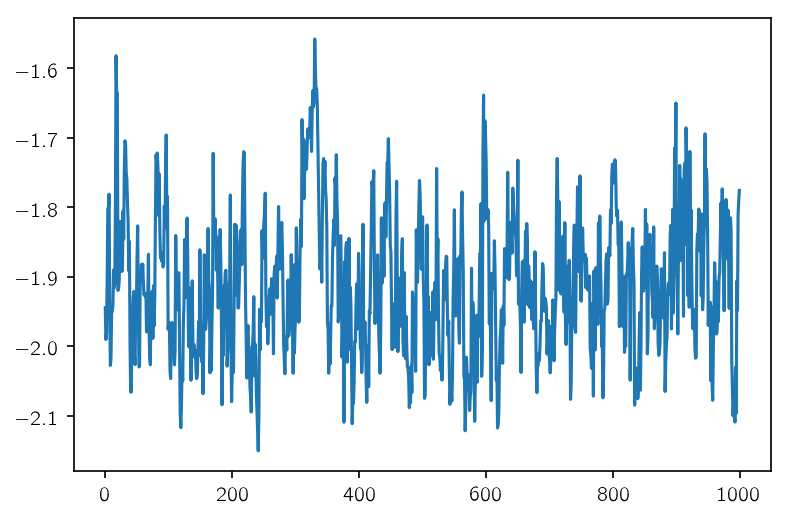

In [71]:
plt.plot(results[0][:, 2]);

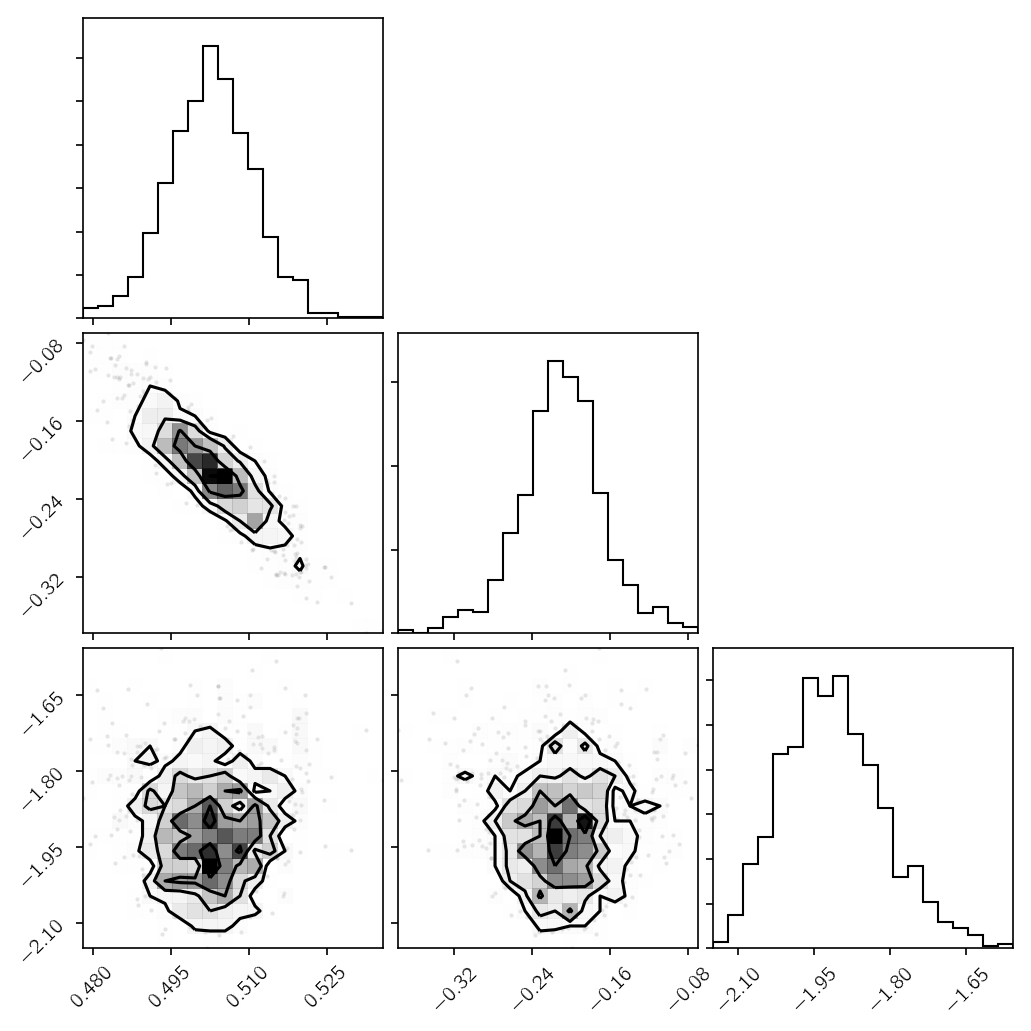

In [72]:
import corner
corner.corner(results[0]);

In [77]:
from simple_hmc import DenseMetric
metric = DenseMetric(3, np.cov(results[0], rowvar=0))
metric.sample_p()

array([-247.83798737,  -28.18651738,  -17.25760504])

In [78]:
results2 = simple_hmc.tf_simple_hmc(session, log_like, var_list, 1000, 0.8, 50, metric)

100%|██████████| 1000/1000 [00:19<00:00, 50.18it/s]


In [79]:
results2[-1]

0.91

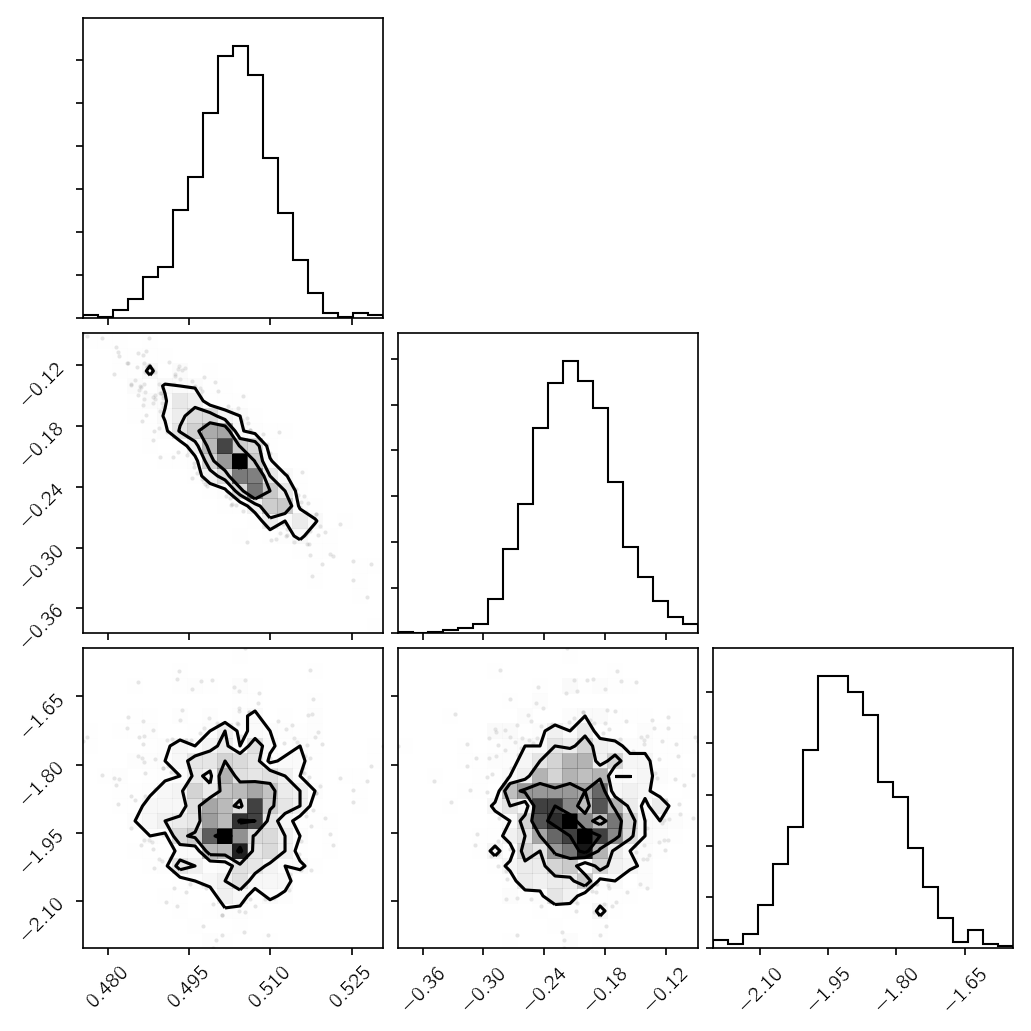

In [80]:
corner.corner(results2[0]);

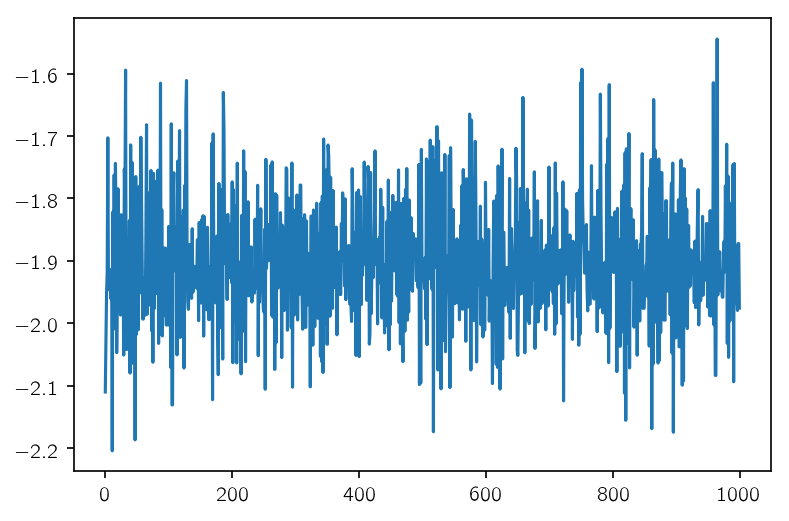

In [84]:
plt.plot(results2[0][:, 2]);